# SPARKIFY PROJECT - DATA EXPLORATION
This notebook explores a tiny subset (128MB) of the full dataset available (12GB).  
Both can be retrieved here:
* 128MB subset: [s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json](s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json)
* full 12GB dataset: [s3n://udacity-dsnd/sparkify/sparkify_event_data.json](s3n://udacity-dsnd/sparkify/sparkify_event_data.json)

After the ***Data Understanding*** phase done in this [notebook](1_Sparkify_Data_Understanding.ipynb), we are now going to define our target feature and then explore the dataset and plot some graphs to analyze the relations between features, distributions and so on.

## Import libraries, init Spark and load dataset

In [1]:
import pyspark
from pyspark.sql import SparkSession, Window

from pyspark.sql.functions import udf, desc, isnan, when, count, col
from pyspark.sql.functions import max as Fmax
from pyspark.sql.types import IntegerType

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import re

%matplotlib inline

In [2]:
# It is useful to know the version we are using when reading the pyspark documentations
pyspark.__version__

'2.4.3'

In [3]:
# Create or retrieve a Spark session
spark = SparkSession.builder.appName("dsnd-p7-sparkify").getOrCreate()

In [4]:
df = spark.read.json("mini_sparkify_event_data.json")
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [5]:
print("Loaded pyspark dataframe has shape ({}, {})".format(df.count(), len(df.columns)))

Loaded pyspark dataframe has shape (286500, 18)


---
# DATA EXPLORATION
# 1. Remove empty users
We have seen in the previous notebook that we had 8346 users with an empty string as `userId` and missing value for `firstName`, `lastName` and so on. Let's remove those users.  
So far in this dataset there are only case with empty string but who knows perhaps there are NaN in the bigger dataset so let's remove NaN as well:

In [6]:
df_clean_users = df.filter((~(isnan(df['userId']))) & (df['userId'].isNotNull()) & (df['userId'] != ""))
print("Cleaned pyspark dataframe has now shape ({}, {})".format(df_clean_users.count(), len(df_clean_users.columns)))

Cleaned pyspark dataframe has now shape (278154, 18)


# 2. Build the `churn` target feature
We have seen that users will be categorized as 'churn' once they have proceed with the `Cancellation confirmation` page.  
In order to do that we will build a User-Defined Function that will be applied on the dataset:

In [7]:
# Define the UDF (do not forget to precise type of column otherwise String is taken by default)
user_has_churned = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# Apply this function on a specific column of the whole dataset
# (made with the help of: https://gist.github.com/zoltanctoth/2deccd69e3d1cde1dd78
# and https://docs.databricks.com/spark/latest/spark-sql/udf-python.html)
df_users_with_churn = df_clean_users.withColumn("churn", user_has_churned("page"))

print("Pyspark dataframe has now shape ({}, {})".format(df_users_with_churn.count(), len(df_users_with_churn.columns)))

Pyspark dataframe has now shape (278154, 19)


Okay we have now one feature more which is our target. Let's confirm that we have 52 users classified as 'churn':

In [8]:
df_users_with_churn.filter(df_users_with_churn['churn'] == 1).count()

52

**That's good but not enough** because so far only rows corresponding to the 'Cancellation confirmation' event have a 1 in the `churn` column but what we want actually is to classify the user as a churn, meaning all his actions, so all the rows related to him.  
For that we will use the **`Window`** pyspark functionality (more about Window [here](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) or [there](https://knockdata.github.io/spark-window-function/)): we partition the data by `userId` and we apply on the column `churn` the max value for the user (so if the user has the event `Cancellation Confirmation` then there is a 1 in `churn` column so max is 1 and we put a 1 in `churn` for all his rows).

In [9]:
df_users_with_churn_full = df_users_with_churn.withColumn("churn", Fmax('churn').over(Window.partitionBy("userId")))

In [10]:
# How many rows does it represents?
df_users_with_churn_full.filter(df_users_with_churn_full['churn'] == 1).count()

44864

In [11]:
# Check that we are still talking about our 52 users
df_users_with_churn_full.filter(df_users_with_churn_full['churn'] == 1).select('userId').dropDuplicates().count()

52

# 3. Who are the churn users?
In order to make some plot we have to convert our Spark DataFrame into pandas DataFrame so that we can use matplotlib and/or seaborn (see [this stackoverflow post](https://stackoverflow.com/questions/53105033/how-do-i-create-a-seaborn-line-plot-for-pyspark-dataframe)). It is mentionned that this operation can be very expensive so we have to ensure to collect only the needed rows.

## 3.1. `Gender` vs. churn

In [12]:
# Convert to pandas only useful data
df_gender_pandas = df_users_with_churn_full.select('userId', 'gender', 'churn').toPandas()

In [13]:
# Check shape to ensure we have right number of rows and our 3 columns
df_gender_pandas.shape

(278154, 3)

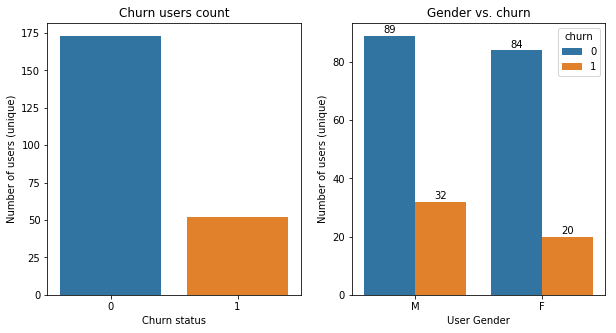

In [14]:
the_data = df_gender_pandas.groupby("userId")['gender', 'churn'].max()
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].set_title("Churn users count")
axis[1].set_title("Gender vs. churn")
sns.countplot(x="churn", data=the_data, ax=axis[0])
sns.countplot(x="gender", hue="churn", data=the_data, ax=axis[1])
axis[0].set_xlabel("Churn status")
axis[0].set_ylabel("Number of users (unique)")
axis[1].set_xlabel("User Gender")
axis[1].set_ylabel("Number of users (unique)")

# Trick to display value on countplot graph
for p in axis[1].patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 1
    value = '{}'.format(p.get_height())
    axis[1].text(_x, _y, value, ha="center")

plt.show()

In [15]:
print("{:.2f}% of churn users are Men - {:.2f}% of Men have churned (opposed to {:.2f}% for Women)".
      format((100*32/52), (100*32/121), (100*20/104)))

61.54% of churn users are Men - 26.45% of Men have churned (opposed to 19.23% for Women)


## 3.2. `Level` vs. churn

In [16]:
df_level_pandas = df_users_with_churn_full.select('userId', 'level', 'churn').toPandas()

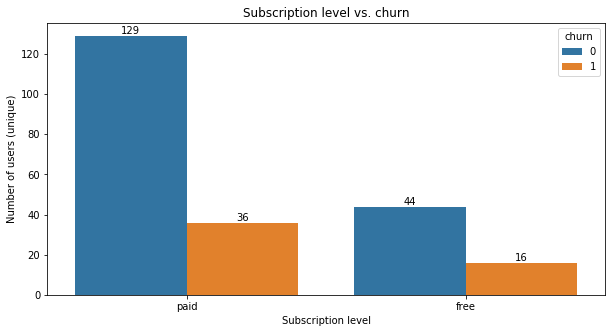

In [17]:
figure, axis = plt.subplots(1, 1, figsize=(10, 5))
axis.set_title("Subscription level vs. churn")
sns.countplot(x="level", hue="churn", data=df_level_pandas.groupby("userId")['level', 'churn'].max(), ax=axis)
axis.set_xlabel("Subscription level")
axis.set_ylabel("Number of users (unique)")

# Trick to display value on countplot graph
for p in axis.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 1
    value = '{}'.format(p.get_height())
    axis.text(_x, _y, value, ha="center")

plt.show()

In [18]:
print("{:.2f}% of churn users had a paid subscription level".format(100*36/52))
print("{:.2f}% of people with paid subscription level have churned (opposed to {:.2f}% for free usage of the service)".format((100*36/165), (100*16/60)))

69.23% of churn users had a paid subscription level
21.82% of people with paid subscription level have churned (opposed to 26.67% for free usage of the service)


## 3.3. `Registration`: for how long have they used the service?
We have seen that the column `registration` refers to the date the user registered to the service, we can analyze for how long did the user tried the service before cancelling.

In [19]:
df_reg_pandas = df_users_with_churn_full.select('userId', 'registration', 'page', 'ts', 'churn').toPandas()
df_reg_pandas['delta_in_days'] = df_reg_pandas.apply(lambda x: (datetime.fromtimestamp(x['ts']/1000) - datetime.fromtimestamp(x['registration']/1000)).days, axis=1)

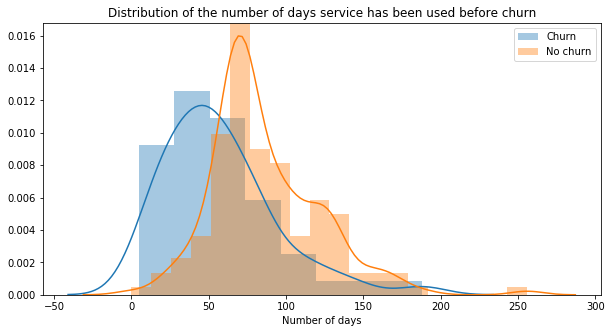

In [20]:
nb_days_service_use = df_reg_pandas.groupby('userId')['delta_in_days', 'churn'].max()

figure, axis = plt.subplots(1, 1, figsize=(10, 5))
axis.set_title("Distribution of the number of days service has been used before churn")
sns.distplot(a=nb_days_service_use[nb_days_service_use['churn'] == 1]['delta_in_days'], ax=axis, label="Churn")
sns.distplot(a=nb_days_service_use[nb_days_service_use['churn'] == 0]['delta_in_days'], ax=axis, label="No churn")
axis.set_xlabel("Number of days")
plt.legend(loc="best")
plt.show()

***Observations:*** in this dataset, **churn users have less used the service**. Perhaps building a feature with the number of days since the registration could be something useful in the modeling part. Once this is said, we must remain cautious about that because, of course, as soon as the user quits this value stops (and that might explain why it is less for churn users).

## 3.4. User engagement with the service
Idea here is that the more a user interacted with the service (number of artists/songs listened, number of sessions, time spent listening) the more chances we have this user enjoys the service and then will not quit. Let's see if there are big differences between churn users and the others.

In [26]:
df_engage_pandas = df_users_with_churn_full.select('userId', 'artist', 'sessionId', 'song', 'length', 'churn').toPandas()

In [27]:
artists_per_user = df_engage_pandas.groupby(['userId', 'churn'])['artist'].nunique().reset_index()
songs_per_user = df_engage_pandas.groupby(['userId'])['song'].nunique().reset_index()
time_listening_per_user = df_engage_pandas.groupby(['userId'])['length'].sum().reset_index()
nb_sessions_per_user = df_engage_pandas.groupby(['userId'])['sessionId'].nunique().reset_index()

# Merge all dataframes into a single one
df_user_engagement = artists_per_user.merge(songs_per_user, on='userId').merge(time_listening_per_user, on='userId').merge(nb_sessions_per_user, on='userId')

In [29]:
df_user_engagement.head(20)

,userId,churn,artist,song,length,sessionId
0,10,0,565,629,166866.37251,6
1,100,0,1705,2302,672877.85659,35
2,100001,1,125,129,35073.74215,4
3,100002,0,184,193,49559.91810,4
4,100003,1,50,51,12306.41932,2
5,100004,0,733,881,231480.38929,21
6,100005,1,149,153,37037.12201,5
7,100006,1,26,26,5854.89105,1
8,100007,1,357,408,104495.32492,9
9,100008,0,623,723,191396.79602,6


In [14]:
df_user_engagement.describe()

,churn,artist,song,length,sessionId
count,225.000000,225.000000,225.000000,2.250000e+02,225.000000
mean,0.231111,696.377778,897.791111,2.525583e+05,14.115556
std,0.422483,603.951870,896.387604,2.753964e+05,14.646885
min,0.000000,3.000000,3.000000,6.916688e+02,1.000000
25%,0.000000,207.000000,226.000000,5.763318e+04,6.000000
50%,0.000000,555.000000,634.000000,1.680938e+05,10.000000
75%,0.000000,1098.000000,1420.000000,3.924015e+05,18.000000
max,1.000000,3544.000000,5946.000000,1.991155e+06,107.000000


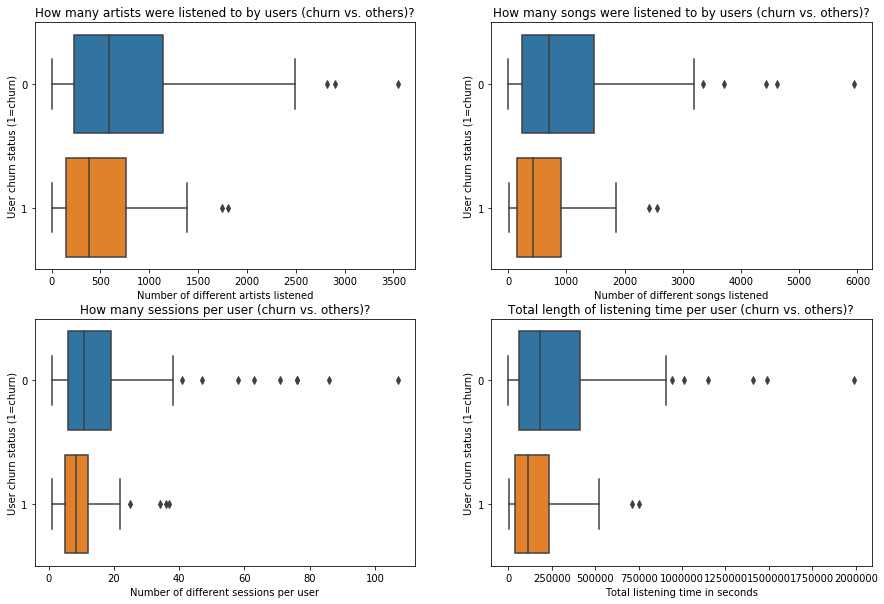

In [18]:
figure, axis = plt.subplots(2, 2, figsize=(15, 10))
axis[0][0].set_title("How many artists were listened to by users (churn vs. others)?")
axis[0][1].set_title("How many songs were listened to by users (churn vs. others)?")
axis[1][0].set_title("How many sessions per user (churn vs. others)?")
axis[1][1].set_title("Total length of listening time per user (churn vs. others)?")

sns.boxplot(x='artist', y='churn', data=df_user_engagement, ax=axis[0][0], orient="h")
sns.boxplot(x='song', y='churn', data=df_user_engagement, ax=axis[0][1], orient="h")
sns.boxplot(x='sessionId', y='churn', data=df_user_engagement, ax=axis[1][0], orient="h")
sns.boxplot(x='length', y='churn', data=df_user_engagement, ax=axis[1][1], orient="h")

axis[0][0].set_ylabel("User churn status (1=churn)")
axis[0][1].set_ylabel("User churn status (1=churn)")
axis[1][0].set_ylabel("User churn status (1=churn)")
axis[1][1].set_ylabel("User churn status (1=churn)")
axis[0][0].set_xlabel("Number of different artists listened")
axis[0][1].set_xlabel("Number of different songs listened")
axis[1][0].set_xlabel("Number of different sessions per user")
axis[1][1].set_xlabel("Total listening time in seconds")

plt.legend(loc="best")
plt.show()

***Observations:***
* **churn users have listened to less unique artists and songs**. It can means that they are less connected with the service but those figures can also be explained because churn users have stopped using the service so the "counter" has stop as well
* **churn users used less the service** (this is seen in the difference of the distribution of the number of different sessions per user)
* in the end, kind of correlated to the number of artists/songs listened, **the total time of listening is far less for churn users** (explained by the 3 previous measures: less connections, less songs listened = less total time)
* note: we could also add the number of times a song/artist has been added to playlist

## 3.5. Social interactions
Kind of the same idea: how many friends did the user add? How many `Thumbs up` or `Thumbs down`? Could it be a clue to detect incoming churn?

In [12]:
df_social_pandas = df_users_with_churn_full.select('userId', 'page', 'churn').toPandas()

In [13]:
df_social_pandas.page.unique()

array(['NextSong', 'Thumbs Up', 'Roll Advert', 'Home', 'Logout',
       'Add to Playlist', 'Help', 'Add Friend', 'Thumbs Down', 'Upgrade',
       'About', 'Settings', 'Submit Upgrade', 'Downgrade', 'Cancel',
       'Cancellation Confirmation', 'Error', 'Save Settings',
       'Submit Downgrade'], dtype=object)

In [14]:
# Gather all information we are interested in by filtering on page type
df_add_friend = df_social_pandas[df_social_pandas['page'] == 'Add Friend'].groupby(['userId']).page.count().reset_index()
df_add_friend.columns = ['userId', 'nb_add_friend']

df_thumbs_up = df_social_pandas[df_social_pandas['page'] == 'Thumbs Up'].groupby(['userId']).page.count().reset_index()
df_thumbs_up.columns = ['userId', 'thumbs_up']

df_thumbs_down = df_social_pandas[df_social_pandas['page'] == 'Thumbs Down'].groupby(['userId']).page.count().reset_index()
df_thumbs_down.columns = ['userId', 'thumbs_down']

df_ads = df_social_pandas[df_social_pandas['page'] == 'Roll Advert'].groupby(['userId']).page.count().reset_index()
df_ads.columns = ['userId', 'ads']

# And then merge everything and replace NaN (due to left-join strategy to keep all users) with 0
df_social_data = df_social_pandas.groupby(['userId']).churn.max().reset_index()
df_social_data = df_social_data.merge(df_add_friend, on='userId', how='left').merge(df_thumbs_up, on='userId', how='left')
df_social_data = df_social_data.merge(df_thumbs_down, on='userId', how='left').merge(df_ads, on='userId', how='left')
df_social_data = df_social_data.fillna(0)

In [15]:
df_social_data.head(10)

,userId,churn,nb_add_friend,thumbs_up,thumbs_down,ads
0,10,0,12.0,37.0,4.0,1.0
1,100,0,49.0,148.0,27.0,25.0
2,100001,1,2.0,8.0,2.0,14.0
3,100002,0,1.0,5.0,0.0,3.0
4,100003,1,0.0,3.0,0.0,9.0
5,100004,0,19.0,35.0,11.0,86.0
6,100005,1,3.0,7.0,3.0,18.0
7,100006,1,4.0,2.0,2.0,3.0
8,100007,1,17.0,19.0,6.0,5.0
9,100008,0,17.0,37.0,6.0,20.0


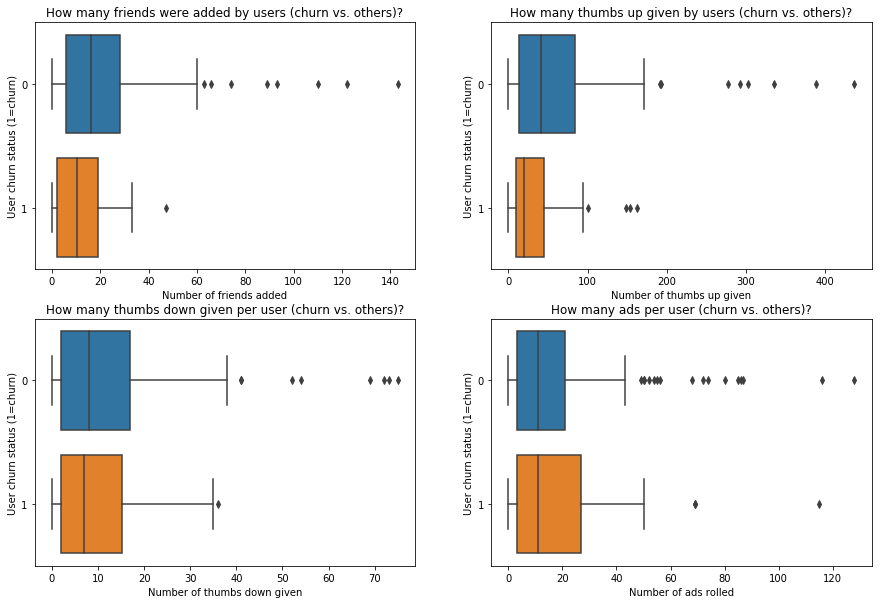

In [28]:
figure, axis = plt.subplots(2, 2, figsize=(15, 10))
axis[0][0].set_title("How many friends were added by users (churn vs. others)?")
axis[0][1].set_title("How many thumbs up given by users (churn vs. others)?")
axis[1][0].set_title("How many thumbs down given per user (churn vs. others)?")
axis[1][1].set_title("How many ads per user (churn vs. others)?")

sns.boxplot(x='nb_add_friend', y='churn', data=df_social_data, ax=axis[0][0], orient="h")
sns.boxplot(x='thumbs_up', y='churn', data=df_social_data, ax=axis[0][1], orient="h")
sns.boxplot(x='thumbs_down', y='churn', data=df_social_data, ax=axis[1][0], orient="h")
sns.boxplot(x='ads', y='churn', data=df_social_data, ax=axis[1][1], orient="h")

axis[0][0].set_ylabel("User churn status (1=churn)")
axis[0][1].set_ylabel("User churn status (1=churn)")
axis[1][0].set_ylabel("User churn status (1=churn)")
axis[1][1].set_ylabel("User churn status (1=churn)")
axis[0][0].set_xlabel("Number of friends added")
axis[0][1].set_xlabel("Number of thumbs up given")
axis[1][0].set_xlabel("Number of thumbs down given")
axis[1][1].set_xlabel("Number of ads rolled")

plt.legend(loc="best")
plt.show()

***Observations:***
* As imagined, there were **less 'positive social interactions' (add a friend, give a like) with the app for churn users.**
* On the other side, the distribution for 'negative social interactions' (dislike/thumbs down) are quite close from each other. That could mean that the recommendations (for example) were not so good and the user gave a thumbs down. Maybe.
* The last one has to be taken with caution because users with a "paid" subscription are listening less (and even no) ads. Though, we can observe that **churn users have rolled ads more than the others**. Perhaps they cancelled due to the amount of ads. Maybe. Again.

## 3.6. `Upgrade/Downgrade`, is there an impact?
While having a look at the different pages, I noticed 2 kind of pages that could be interesting ones: `Upgrade` and `Downgrade`. Intuition here is to say that if user has upgraded the service he is now more engaged whereas, on the other side, the "downgrade" step could be the first step towards the churn.  
Let's try to see if this is correct.

In [38]:
# Collect what we need
df_upgraded = df_social_pandas[df_social_pandas['page'] == 'Upgrade'].groupby(['userId']).page.count().reset_index()
df_downgraded = df_social_pandas[df_social_pandas['page'] == 'Downgrade'].groupby(['userId']).page.count().reset_index()
df_upgraded.columns = ['userId', 'think_upgrade']
df_downgraded.columns = ['userId', 'think_downgrade']

df_upgraded_real = df_social_pandas[df_social_pandas['page'] == 'Submit Upgrade'].groupby(['userId']).page.count().reset_index()
df_downgraded_real = df_social_pandas[df_social_pandas['page'] == 'Submit Downgrade'].groupby(['userId']).page.count().reset_index()
df_upgraded_real.columns = ['userId', 'has_upgraded']
df_downgraded_real.columns = ['userId', 'has_downgraded']

In [39]:
# And then merge everything and replace NaN (due to left-join strategy to keep all users) with 0
df_up_down = df_social_pandas.groupby(['userId']).churn.max().reset_index()
df_up_down = df_up_down.merge(df_upgraded, on='userId', how='left').merge(df_downgraded, on='userId', how='left')
df_up_down = df_up_down.merge(df_upgraded_real, on='userId', how='left').merge(df_downgraded_real, on='userId', how='left')
df_up_down = df_up_down.fillna(0)

In [40]:
df_up_down.head(10)

,userId,churn,think_upgrade,think_downgrade,has_upgraded,has_downgraded
0,10,0,0.0,7.0,0.0,0.0
1,100,0,1.0,30.0,1.0,1.0
2,100001,1,2.0,0.0,0.0,0.0
3,100002,0,0.0,2.0,0.0,0.0
4,100003,1,0.0,0.0,0.0,0.0
5,100004,0,8.0,10.0,3.0,2.0
6,100005,1,4.0,0.0,0.0,0.0
7,100006,1,0.0,0.0,0.0,0.0
8,100007,1,0.0,7.0,0.0,0.0
9,100008,0,4.0,10.0,0.0,1.0


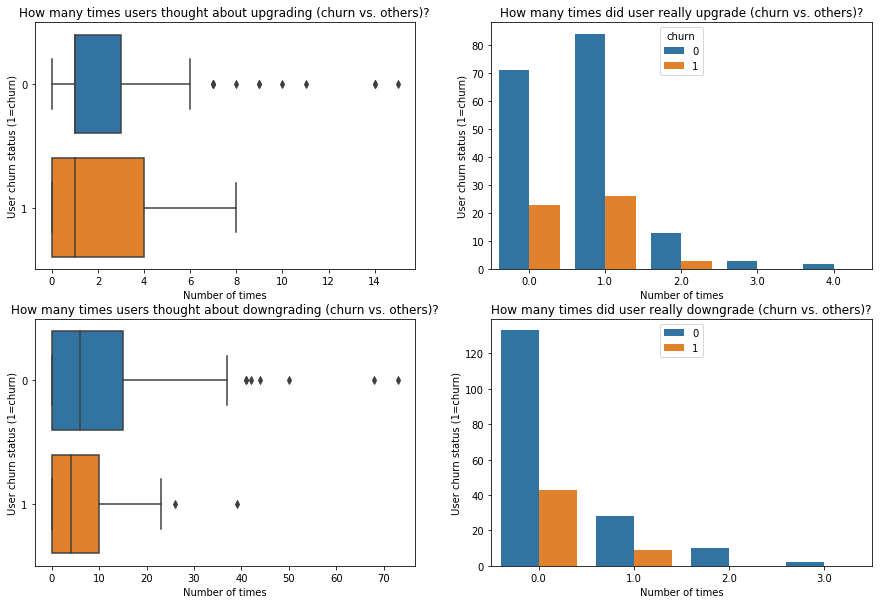

In [44]:
figure, axis = plt.subplots(2, 2, figsize=(15, 10))
axis[0][0].set_title("How many times users thought about upgrading (churn vs. others)?")
axis[0][1].set_title("How many times did user really upgrade (churn vs. others)?")
axis[1][0].set_title("How many times users thought about downgrading (churn vs. others)?")
axis[1][1].set_title("How many times did user really downgrade (churn vs. others)?")

sns.boxplot(x='think_upgrade', y='churn', data=df_up_down, ax=axis[0][0], orient="h")
sns.countplot(x='has_upgraded', hue='churn', data=df_up_down, ax=axis[0][1], orient="h")
sns.boxplot(x='think_downgrade', y='churn', data=df_up_down, ax=axis[1][0], orient="h")
sns.countplot(x='has_downgraded', hue='churn', data=df_up_down, ax=axis[1][1], orient="h")

axis[0][0].set_ylabel("User churn status (1=churn)")
axis[0][1].set_ylabel("User churn status (1=churn)")
axis[1][0].set_ylabel("User churn status (1=churn)")
axis[1][1].set_ylabel("User churn status (1=churn)")
axis[0][0].set_xlabel("Number of times")
axis[0][1].set_xlabel("Number of times")
axis[1][0].set_xlabel("Number of times")
axis[1][1].set_xlabel("Number of times")

plt.legend(loc="best")
plt.show()

***Observations:***
* Even if a lot of churn users thought about upgrading, actually few of them really did and most of the people who have upgraded stayed engaged with the service.
* On the other side, some non churn users thought about downgrading but few did and even among the ones who did, most of them stayed in the end.

## 3.7. Is the app working fine?
### 3.7.1. Explore the user's Operating System
We have seen during the Data Understanding phase that we have information about the user's browser user-agent. We could try to extract some information such as the underlying Operating System or even maybe the device. We could also count the number of errors the user encountered (either via HTTP code 404 or for page=Error, etc.). Maybe a lot (and recurrent) errors would lead some users to churn.

In [119]:
df_useragent_pandas = df_users_with_churn_full.select('userId', 'userAgent', 'churn').toPandas()

In [120]:
df_useragent_pandas.userAgent.unique()

array([ '"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"',
       '"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D167 Safari/9537.53"',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
       '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
       'Mozilla/5.0 (Windows NT 6.1; rv:31.0) Gecko/20100101 Firefox/31.0',
       'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"',
       'Mozilla/5.0 (Win

How can we extract browser or even device? [Here is a good starting point](https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/User-Agent):
> ```User-Agent: Mozilla/<version> (<system-information>) <platform> (<platform-details>) <extensions>```

In [121]:
# Define the regex (regex101 is your friend to validate it works!)
def extract_systeminfo(txt):
    matches = re.match(".*Mozilla/[0-9.]+\s\(([a-zA-Z0-9\s.]+)(;|\))", txt)
    if matches:
        return matches.group(1)
    else:
        return ""

In [122]:
# Check it anyway on one random value
extract_systeminfo('"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"')

'iPhone'

In [123]:
df_useragent_pandas['system_info'] = df_useragent_pandas['userAgent'].apply(lambda x: extract_systeminfo(x))
# df_useragent_pandas.drop(['userAgent'], axis=1, inplace=True)
df_sysinfo = df_useragent_pandas.groupby(['userId', 'system_info']).churn.max().reset_index()
df_sysinfo.head(10)

,userId,system_info,churn
0,10,Macintosh,0
1,100,Windows NT 6.1,0
2,100001,Macintosh,1
3,100002,Windows NT 6.1,0
4,100003,Windows NT 6.1,1
5,100004,compatible,0
6,100005,Macintosh,1
7,100006,Windows NT 6.3,1
8,100007,Windows NT 6.3,1
9,100008,Macintosh,0


In [124]:
df_sysinfo.system_info.value_counts()

Macintosh         86
Windows NT 6.1    80
Windows NT 6.3    16
iPhone            13
X11               12
compatible         5
Windows NT 5.1     5
Windows NT 6.2     4
iPad               3
Windows NT 6.0     1
Name: system_info, dtype: int64

In [127]:
# What is 'compatible'?
df_useragent_pandas[df_useragent_pandas['system_info'] == 'compatible'].userAgent.unique()

array(['Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)',
       'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)',
       'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)'], dtype=object)

Perform some replacements with the help of this [wikipedia](https://en.wikipedia.org/wiki/List_of_Microsoft_Windows_versions) page:
* Just here (because it would perhaps not be the same everywhere), replace 'compatible' with Windows NT 6.1
* X11 is Linux system
* Windows NT 5.1 is Windows XP
* Windows NT 6.0 is Windows Vista
* Windows NT 6.1 is Windows Seven
* Windows NT 6.2 is Windows 8
* Windows NT 6.3 is Windows 8.1

In [130]:
df_sysinfo.system_info.replace('compatible', 'Windows NT 6.1', inplace=True)
df_sysinfo.system_info.replace('X11', 'Linux', inplace=True)
df_sysinfo.system_info.replace('Windows NT 5.1', 'Windows XP', inplace=True)
df_sysinfo.system_info.replace('Windows NT 6.0', 'Windows Vista', inplace=True)
df_sysinfo.system_info.replace('Windows NT 6.1', 'Windows Seven', inplace=True)
df_sysinfo.system_info.replace('Windows NT 6.2', 'Windows 8', inplace=True)
df_sysinfo.system_info.replace('Windows NT 6.3', 'Windows 8.1', inplace=True)
df_sysinfo.system_info.value_counts()

Macintosh        86
Windows Seven    85
Windows 8.1      16
iPhone           13
Linux            12
Windows XP        5
Windows 8         4
iPad              3
Windows Vista     1
Name: system_info, dtype: int64

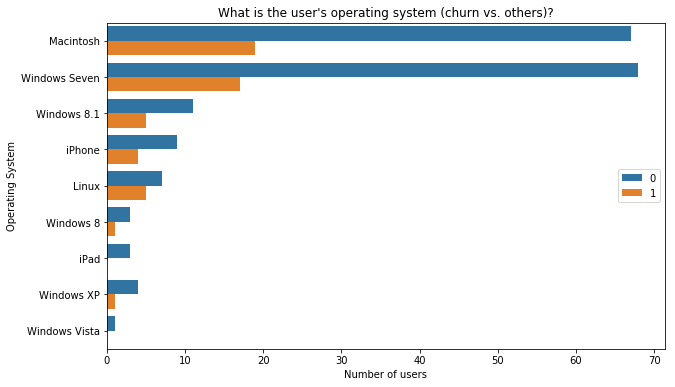

In [146]:
figure, axis = plt.subplots(1, 1, figsize=(10, 6))
axis.set_title("What is the user's operating system (churn vs. others)?")
sns.countplot(y='system_info', hue='churn', data=df_sysinfo, ax=axis, orient="h")
axis.set_ylabel("Operating System")
axis.set_xlabel("Number of users")
plt.legend(loc="best")
plt.show()

***Observations:*** in this dataset people with a Mac are the ones who have churned most (but they are also the most represented users!). I would highliht 'Linux' users that are near 40/60% of churn/no churn.

In [173]:
df_sysinfo_tot = df_sysinfo.groupby(['system_info']).churn.count().reset_index()
df_sysinfo_tot = df_sysinfo_tot.merge(df_sysinfo[df_sysinfo['churn'] == 0].groupby(['system_info']).churn.count().reset_index(), on='system_info')
df_sysinfo_tot = df_sysinfo_tot.merge(df_sysinfo[df_sysinfo['churn'] == 1].groupby(['system_info']).churn.count().reset_index(), on='system_info')
df_sysinfo_tot.columns = ['system_info', 'total', 'churn_0', 'churn_1']
df_sysinfo_tot['perc_churn'] = np.round(100*(df_sysinfo_tot['churn_1']/df_sysinfo_tot['total']), 2)
df_sysinfo_tot.sort_values(by='perc_churn', ascending=False)

,system_info,total,churn_0,churn_1,perc_churn
0,Linux,12,7,5,41.67
3,Windows 8.1,16,11,5,31.25
6,iPhone,13,9,4,30.77
2,Windows 8,4,3,1,25.00
1,Macintosh,86,67,19,22.09
4,Windows Seven,85,68,17,20.00
5,Windows XP,5,4,1,20.00


***Note***: as observed, it seems that people under Linux are suffering a bad experience and so they cancel their subscription.

### 3.7.2. How many errors encountered per user?
We have seen that there are some elements in the dataset that are related to errors:
* HTTP code 404
* page 'Error'

In [20]:
df_error_pandas = df_users_with_churn_full.select('userId', 'page', 'status', 'churn').toPandas()

In [22]:
# Gather all information we are interested in by filtering on page type
df_err_page = df_error_pandas[df_error_pandas['page'] == 'Error'].groupby(['userId']).page.count().reset_index()
df_err_page.columns = ['userId', 'nb_error_pages']

df_err_status = df_error_pandas[df_error_pandas['status'] == 404].groupby(['userId']).page.count().reset_index()
df_err_status.columns = ['userId', 'nb_404']

# And then merge everything and replace NaN (due to left-join strategy to keep all users) with 0
df_error_data = df_error_pandas.groupby(['userId']).churn.max().reset_index()
df_error_data = df_error_data.merge(df_err_page, on='userId', how='left').merge(df_err_status, on='userId', how='left')
df_error_data = df_error_data.fillna(0)

In [23]:
df_error_data.head(10)

,userId,churn,nb_error_pages,nb_404
0,10,0,0.0,0.0
1,100,0,3.0,3.0
2,100001,1,1.0,1.0
3,100002,0,0.0,0.0
4,100003,1,0.0,0.0
5,100004,0,2.0,2.0
6,100005,1,0.0,0.0
7,100006,1,0.0,0.0
8,100007,1,0.0,0.0
9,100008,0,0.0,0.0


In [24]:
# Are the values different actually?
df_error_data['err_diff'] = df_error_data['nb_error_pages'] - df_error_data['nb_404']
df_error_data['err_diff'].sum()

0.0

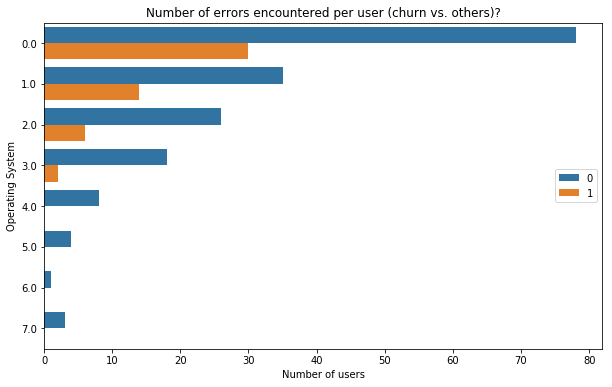

In [25]:
figure, axis = plt.subplots(1, 1, figsize=(10, 6))
axis.set_title("Number of errors encountered per user (churn vs. others)?")
sns.countplot(y='nb_404', hue='churn', data=df_error_data, ax=axis, orient="h")
axis.set_ylabel("Operating System")
axis.set_xlabel("Number of errors")
plt.legend(loc="best")
plt.show()

It is not so obvious, _in this dataset_ to make a conclusion about the number of errors and the churn as there were few errors actually and even with errors, most of the people stayed. And some quit even if they had no error.

---
# CONCLUSION
We have now seen a lot of graphs and have a better idea of what could help us to detect churn. For example:
* `level` of subscription
* `registration` time for the user
* `engagement` of the user with the number of artists, songs or even the total length of music listened, add to playlist number
* `social interactions` with likes/dislikes, friends, etc
* `upgrade/downgrade` the subscription level
* `user operating system` which could help us to identify users of a version that does not give entire satisfaction
* `errors_encountered` which could help us to identify users who had several issues and then maybe quit

We can now start the next part, the modeling phase. This will be done in this [notebook](3_Sparkify_Modeling.ipynb).